### Import libraries

In [1]:
import torch
import cv2
import os
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd


### Load model function

In [2]:
def load_model(model_path):
    model = torch.jit.load(model_path)
    model.eval()
    return model


### Preprocessing function

In [3]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension


### Display Image & run classification

In [4]:
def display_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Predicted: {label}')
    plt.show()


#### Function to `classify_and_display_images` when file_path is in a list

In [5]:
def classify_and_display_images(model, image_paths, device, output_csv):
    results = []
    for image_path in image_paths:
        image_tensor = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)  # Move tensor to the device
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            scores, predicted_labels = torch.max(probabilities, dim=1)
            predicted_label_id = predicted_labels.item()
            predicted_label = model.get_class_label(torch.tensor(predicted_label_id).to(device))  # Pass tensor to the device
            predicted_score = scores.item()
        results.append({
            'ImageName': os.path.basename(image_path),
            'PredictedLabel': predicted_label,
            'PredictionScore': predicted_score,
            'PredictedLabelID': predicted_label_id,
            # Add other tags as needed
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)  # Save DataFrame to CSV without index
    for index, row in df.iterrows():
        display_image(image_paths[index], row[['PredictedLabel', 'PredictionScore', 'PredictedLabelID']])
    return df


### Function to `classify_images_from_folder`

In [6]:
def classify_images_from_folder(model, folder_path, device, output_csv):
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('jpg', 'png'))]
    
    results = []
    for image_path in image_paths:
        image_name = os.path.basename(image_path)
        image_tensor = preprocess_image(image_path)
        with torch.no_grad():
            output = model(image_tensor.to(device))
            probabilities = torch.softmax(output, dim=1)
            scores, predicted_labels = torch.max(probabilities, dim=1)
            predicted_label_id = predicted_labels.item()
            predicted_label = model.get_class_label(torch.tensor(predicted_label_id).to(device))  # Pass tensor to the device
            predicted_score = scores.item()
        results.append({
            'ImageName': image_name,
            'PredictedLabel': predicted_label,
            'PredictionScore': predicted_score,
            'PredictedLabelID': predicted_label_id,
            # Add other tags as needed
        })
    
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)  # Save DataFrame to CSV without index
    for index, row in df.iterrows():
        display_image(image_paths[index], row[['PredictedLabel', 'PredictionScore', 'PredictedLabelID']])
    return df


### Load the model

In [7]:
model_path = 'traffic_sign_model.pt'  # Path to the saved TorchScript model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(model_path).to(device)
model.eval()


RecursiveScriptModule(
  original_name=TrafficSignNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (dropout_fc): RecursiveScriptModule(original_name=Dropout)
)

### Load Images & execute model_analysis scripts

#### CASE 1: For single Image path or list of Images

In [8]:
# Classify path of single image or a list of images
output_csv = 'model_predictions.csv'
list_of_image_paths = ['Datasets/Test/12624.png', 'Datasets/Test/12629.png']


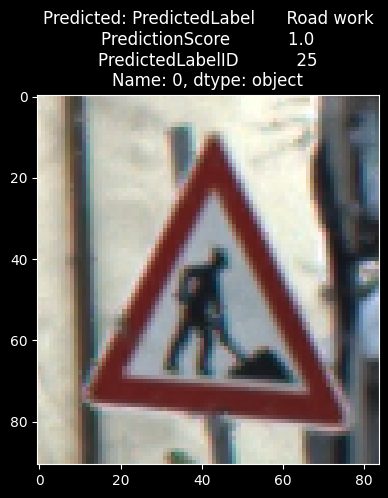

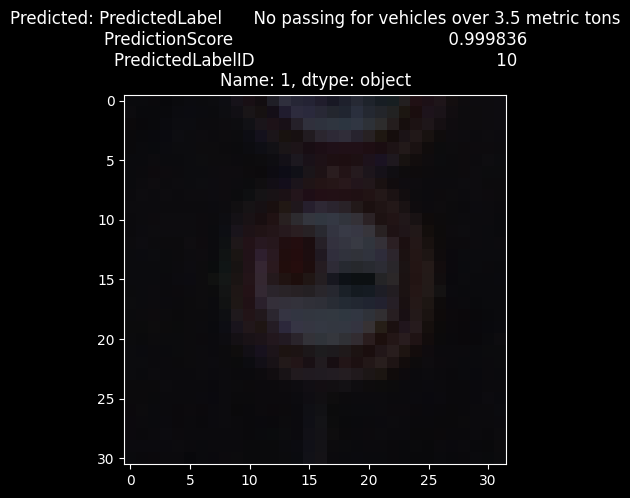

,ImageName,PredictedLabel,PredictionScore,PredictedLabelID
0,12624.png,Road work,1.000000,25
1,12629.png,No passing for vehicles over 3.5 metric tons,0.999836,10


In [9]:
classify_and_display_images(model, list_of_image_paths, device, output_csv)  # List of images


#### CASE2: When there's multiple Images
When multiple images, load all images in the folder and then run below script

In [10]:
# Classify all images in a folder
output_csv = 'model_predictions.csv'
image_folder_path = 'Datasets/Test'


In [ ]:
classify_images_from_folder(model, image_folder_path, device, output_csv)
